In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv
/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv


### Імпорти

In [3]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
# from torchnlp.datasets import imdb_dataset
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Для стабілізації виводу.

In [4]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

## Підготовка даних

In [5]:
path = '../input/imdb-50k-movie-reviews-test-your-bert/'

train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')

In [6]:
# experimenting here with a sample of dataset, to avoid memory overflow.
train_data = train_data[:2000]
test_data = test_data[:500]

train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
type(train_data)

list

### Співставлення текстів з їхніми маркуваннями

In [7]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(2000, 2000, 500, 500)

#### Візуалізація одного з відгуків з бази

In [8]:
train_texts[0]

"Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it."

## Візуалізація довжин речень

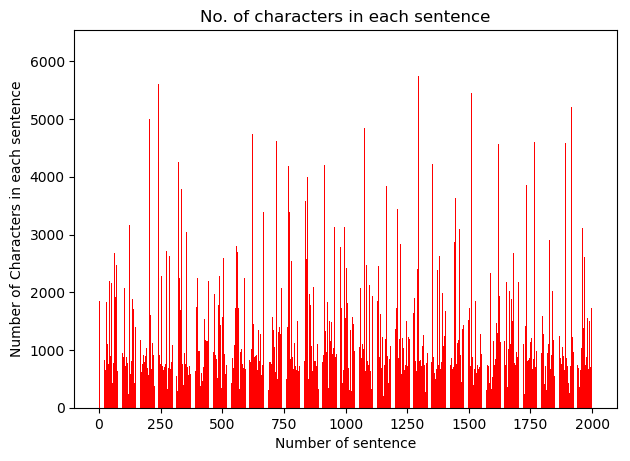

In [9]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,2001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

#### Більшість мають 700 - 1000 символів, що є очевидно. є трохи коротких і дуже довгих (6к символів), отже це хороший датасет

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 5688196.33B/s]


In [11]:
tokenizer.tokenize('Hi my name is Atul')

['hi', 'my', 'name', 'is', 'at', '##ul']

### Зразок того, як працює BERT-токенізер і вбудовування, приготоване для живлення в BERT-модель.

![BERT TOKENS](https://miro.medium.com/max/619/1*iJqlhZz-g6ZQJ53-rE9VvA.png)

## Підготовка до вбудовування токену...

In [12]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(2000, 500)

## Підготовка id токену...


![token ids](https://jalammar.github.io/images/distilBERT/sst2-text-to-tokenized-ids-bert-example.png)

In [13]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((2000, 512), (500, 512))

In [14]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((2000,), (500,), 0.4855, 0.508)

### Маскуємо рандомні ID з кожного відгуку і видаляємо зміщення з моделі.

In [15]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# Базова лінія

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [17]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
baseline_predicted = baseline_model.predict(test_texts)

In [19]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.82      0.84      0.83       246
         pos       0.84      0.83      0.83       254

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



#### Модель добре працює і видає справедливий результат. Тепер розглянемо BERT модель.

# BERT Модель


### Bidirectional Encoder Representations from Transformers.

In [20]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [21]:
# впевнимось, що модель працює на GPU, і не на CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [23]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

100%|██████████| 407873900/407873900 [00:09<00:00, 41321640.88B/s]


In [24]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [25]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [26]:
y = bert_clf(x)
y.cpu().detach().numpy()        # kinda Garbage Collector to free up used and cache space

array([[0.4249209 ],
       [0.4760142 ],
       [0.37757647]], dtype=float32)

In [27]:
# Cross- checking CUDA GPU Memory to ensure GPU memory is not overflowing.
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'6697.349632M'

In [28]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

# Налаштування BERT

In [29]:
# Setting hyper-parameters

BATCH_SIZE = 4
EPOCHS = 10

In [30]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [31]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [32]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [33]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [34]:
torch.cuda.empty_cache()   # Читимо кеш для нового запуску моделі

In [35]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  8
135/500.0 loss: 0.041652483177826716 
1767.034368M


In [36]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])


In [37]:
np.mean(bert_predicted)

0.5

In [38]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

       False       0.90      0.91      0.90       246
        True       0.91      0.90      0.90       254

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



#### Кращий результат з BERT.